# Exploratory Data Analysis

In [1]:
import os
import time
import torch
import random
import numpy as np
import pprint

from torch import nn, Tensor
from torch.utils.data import DataLoader

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt
from matplotlib import cm

from src.pipelines.lunarlander.preprocessing import (
    collate_fn,
    get_dataset_stats,
    create_trajectory_chunks,
    create_normalized_chunks,
    unnormalize_trajectory,
)

from src.models.backbone import MLP, TemporalCNN, ConditionalTemporalCNN

# minari dataset
import minari
from src.utils.loggers import WandBLogger

# To avoid meshgrid warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)


Using gpu


## Some Basic Dataset Statistics


In [2]:
def visualize_dataset(dataset):
    episode_lengths = []
    aggregated_rewards = []

    for eps in dataset.episode_indices:
        episode = dataset[eps]
        episode_lengths.append(episode.observations.shape[0])    
        aggregated_rewards.append(np.sum(episode.rewards))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(episode_lengths, bins=50, edgecolor='black')
    plt.title('Distribution of Episode Lengths')
    plt.xlabel('Episode Length')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(aggregated_rewards, bins=50, edgecolor='black')
    plt.title('Distribution of Aggregated Rewards per Episode')
    plt.xlabel('Aggregated Reward')
    plt.ylabel('Frequency')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

    print(f"Total number of episodes: {len(episode_lengths)}")
    print(f"Average episode length: {np.mean(episode_lengths):.2f}")
    print(f"Min episode length: {np.min(episode_lengths)}")
    print(f"Max episode length: {np.max(episode_lengths)}")
    print(f"Average aggregated reward: {np.mean(aggregated_rewards):.2f}")
    print(f"Min aggregated reward: {np.min(aggregated_rewards):.2f}")
    print(f"Max aggregated reward: {np.max(aggregated_rewards):.2f}")

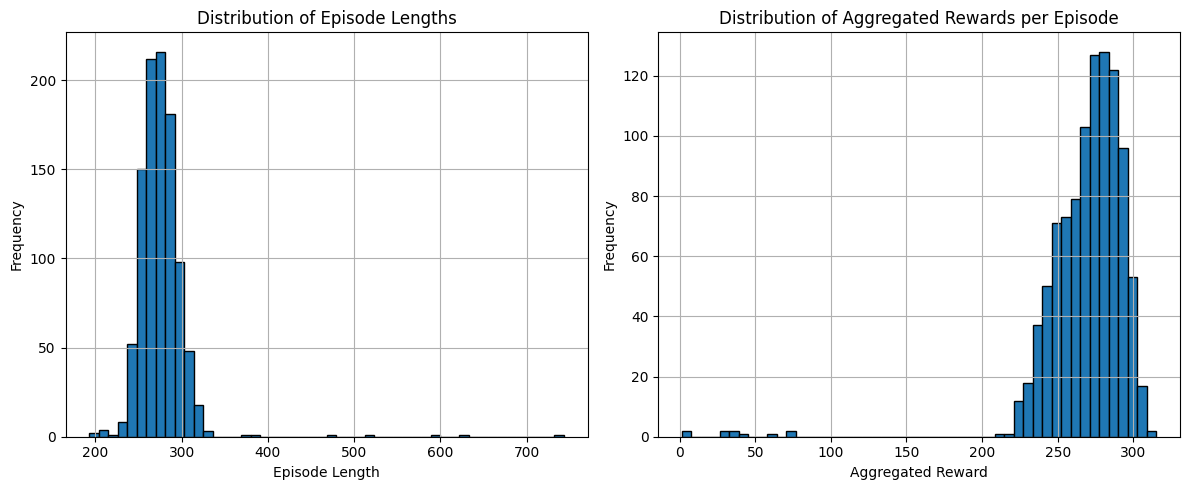

Total number of episodes: 1000
Average episode length: 275.36
Min episode length: 193
Max episode length: 743
Average aggregated reward: 268.92
Min aggregated reward: 1.48
Max aggregated reward: 315.24


{'obs_mean': tensor([-2.6158e-02,  4.6646e-01,  4.3395e-03, -2.2876e-01, -1.2054e-02,
         -6.0773e-05,  2.1673e-01,  2.1720e-01]),
 'obs_std': tensor([0.1075, 0.4694, 0.1949, 0.1756, 0.1438, 0.1310, 0.4120, 0.4123]),
 'act_mean': tensor([-0.1251, -0.0706]),
 'act_std': tensor([0.5542, 0.4226]),
 'rew_mean': tensor(268.9238),
 'rew_std': tensor(30.0081)}

In [3]:
horizon = 100
obs_dim = 8
action_dim = 2
dataset_name = "LunarLanderContinuous-v3/ppo-1000-deterministic-v1"
minari_dataset = minari.load_dataset(dataset_id=dataset_name)
minari_dataset_stats = get_dataset_stats(minari_dataset)
visualize_dataset(minari_dataset)
minari_dataset_stats

## Trajectory Visualization from Expert Dataset

In [4]:
def visualize_chunk(ax, chunk, color, x_limits=(-0.6, 0.6), y_limits=(-0.2, 1.6), mode='line'):
    ax.fill_between([-0.2, 0.2], -0.02, 0, color='gold', alpha=0.8, zorder=1, label='Landing Pad')
    x = chunk[:, 0].cpu().numpy()
    y = chunk[:, 1].cpu().numpy()
    if mode == 'line':
        ax.plot(x, y, linestyle='-', color=color, alpha=0.7)
    elif mode == 'scatter':
        ax.scatter(x, y, color=color, alpha=0.7)
    ax.set_xlim(*x_limits)
    ax.set_ylim(*y_limits)
    ax.grid(True)

Visualing random chunks from each batch...


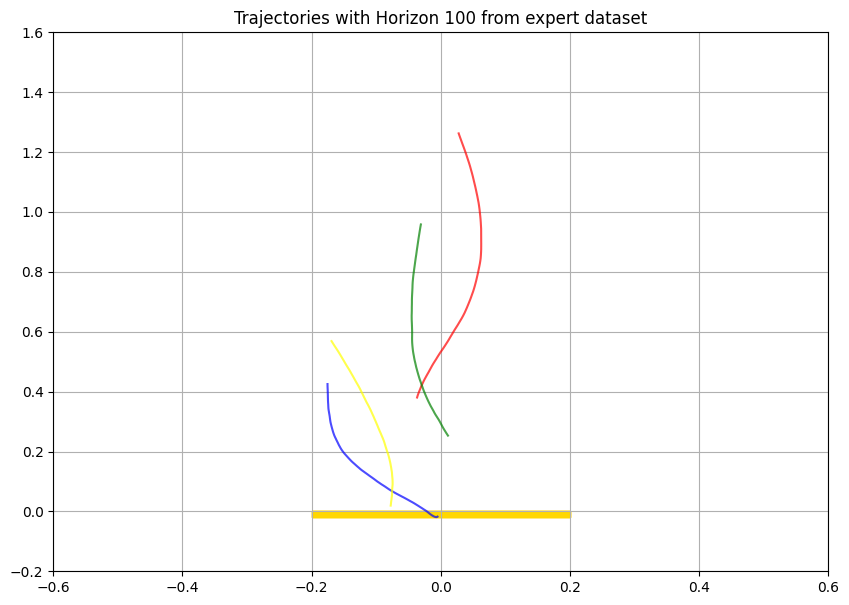

In [5]:
dataloader = DataLoader(minari_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with Horizon {horizon} from expert dataset')
print("Visualing random chunks from each batch...")
colors = ['red', 'green', 'blue', 'yellow']
for idx, batch in enumerate(dataloader):
    processed_chunks = create_trajectory_chunks(batch, horizon)
    # processed_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
    # processed_chunks, conds = create_normalized_chunks(batch, horizon, minari_dataset_stats, conditional=True)
    random_chunk = random.choice(processed_chunks)
    assert random_chunk.shape == (horizon * (obs_dim + action_dim),)
    random_chunk = random_chunk.reshape(horizon, obs_dim + action_dim)
    expert_obs = random_chunk[:, :obs_dim]
    visualize_chunk(ax, expert_obs, color=colors[idx % len(colors)], mode="line")

# Training 🏋️

## Conditional Generation on Starting Observation

In [5]:
# Training params
horizon = 100
lr = 1e-3
num_epochs = 100
print_every = 10
hidden_dim = 256
batch_size = 32
kernel_size = 10

# Preparing the dataset
dataset_name = "LunarLanderContinuous-v3/ppo-1000-deterministic-v1"
minari_dataset =minari.load_dataset(dataset_id=dataset_name)
env = minari_dataset.recover_environment()
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
input_dim = (obs_dim + action_dim) * horizon
transition_dim = obs_dim + action_dim
cond_dim = obs_dim
minari_dataset_stats = get_dataset_stats(minari_dataset)
dataloader = DataLoader(minari_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# model_type = "TemporalCNN"
model_type = "ConditionalTemporalCNN"

# config for wandb
config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "kernel_size": kernel_size,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "model_type": model_type,
    "lr": lr
}

SAVE_DIR = "src/checkpoints"
run_name = f"{model_type}_h{horizon}_e{num_epochs}_k{kernel_size}_start_obs"
MODEL_NAME = run_name + ".pth"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
pp = pprint.PrettyPrinter(indent=2)
print("Training configuration:")
pp.pprint(config)
print("Run name:", run_name)

Training configuration:
{ 'action_dim': 2,
  'batch_size': 32,
  'hidden_dim': 256,
  'horizon': 100,
  'input_dim': 1000,
  'kernel_size': 10,
  'lr': 0.001,
  'model_type': 'ConditionalTemporalCNN',
  'num_epochs': 100,
  'obs_dim': 8}
Run name: ConditionalTemporalCNN_h100_e100_k10_start_obs


In [9]:
logger = WandBLogger(config = config, run_name=run_name)
vf = ConditionalTemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim, cond_dim=cond_dim, kernel_size=kernel_size).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)
print("Starting training...")
for epoch in range(num_epochs):
    total_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()

        x_1, c = create_normalized_chunks(batch, horizon, minari_dataset_stats, cond_type="start_obs")
        if x_1 is None:
            continue
        x_1 = x_1.to(device)
        c = c.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        # 3. Forward pass and Loss
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t, c)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        # 4. Backward pass and Optimize
        loss.backward()
        optim.step()
        total_loss += loss.item()
        total_chunks += 1

    epoch_loss = total_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"epoch loss": epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {epoch_loss:8.5f} ")
        start_time = time.time()
print("Training finished, saving model...")
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(vf.state_dict(), MODEL_SAVE_PATH)
logger.save_model(MODEL_SAVE_PATH)
logger.finish()

print(f"Model saved to {MODEL_SAVE_PATH}, training complete.")

Initializing WandB logger...


Starting training...
| Epoch     10 | 18.09 s/epoch | Loss  0.22501 
| Epoch     20 | 41.74 s/epoch | Loss  0.17625 
| Epoch     30 | 30.95 s/epoch | Loss  0.15667 
| Epoch     40 | 31.93 s/epoch | Loss  0.14875 
| Epoch     50 | 30.90 s/epoch | Loss  0.14040 
| Epoch     60 | 25.85 s/epoch | Loss  0.14180 
| Epoch     70 | 24.86 s/epoch | Loss  0.13275 
| Epoch     80 | 18.48 s/epoch | Loss  0.12676 
| Epoch     90 | 53.39 s/epoch | Loss  0.12551 
| Epoch    100 | 31.29 s/epoch | Loss  0.12333 
Training finished, saving model...
Saving src/checkpoints/ConditionalTemporalCNN_h100_e100_k10_start_obs.pth to WandB artifacts...
Model artifact saved.


epoch loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch loss,0.12333


WandB run finished.
Model saved to src/checkpoints/ConditionalTemporalCNN_h100_e100_k10_start_obs.pth, training complete.


Loading model from src/checkpoints/ConditionalTemporalCNN_h100_e100_k10_start_obs.pth...


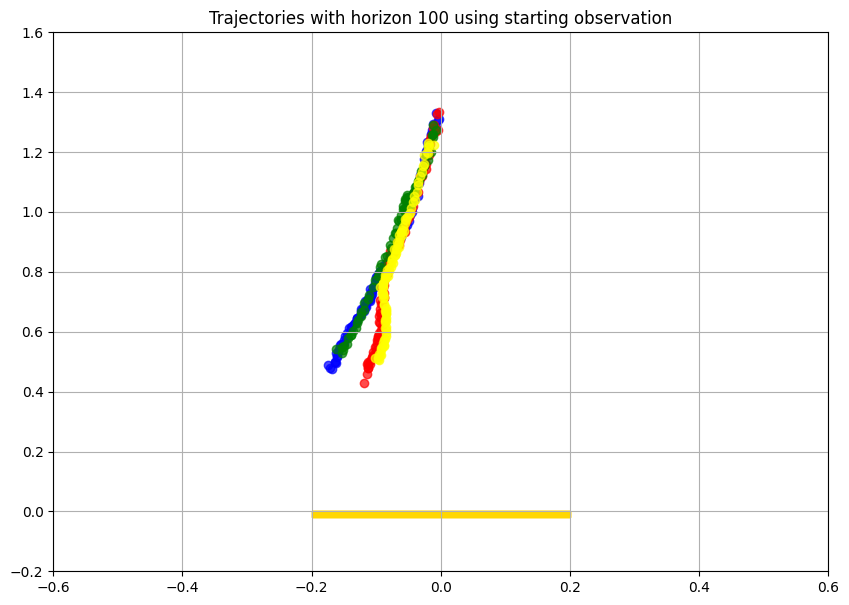

In [9]:
# try sampling from trained model...
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)


class WrappedConditionalModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, c: torch.Tensor, **extras):
        return self.model(x, t, c)


print(f"Loading model from {MODEL_SAVE_PATH}...")
state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
# vf = TemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim).to(device)
vf = ConditionalTemporalCNN(
    horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim, cond_dim=cond_dim, kernel_size=kernel_size
).to(device)
vf.load_state_dict(state_dict)
# wrapped_vf = WrappedModel(vf)
wrapped_vf = WrappedConditionalModel(vf)
step_size = 0.05
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class


def generate_trajectory(stats, condition: dict, batch_size: int = 1):
    """
    Generates a trajectory based on a provided condition dictionary.

    Args:
        stats (dict): The dataset statistics for normalization.
        condition (dict): A dictionary specifying the condition,
                          e.g., {'reward': 250.0} or {'start_obs': tensor}.
        batch_size (int): The number of trajectories to generate.
    """
    # Prepare the condition tensor `c` based on the dictionary keys
    if 'reward' in condition:
        rew_mean = stats['rew_mean'].to(device)
        rew_std = stats['rew_std'].to(device)
        norm_c = (torch.tensor([condition['reward']], device=device) - rew_mean) / rew_std
        c_tensor = norm_c.view(1, 1).expand(batch_size, -1) # Shape: (batch_size, 1)

    elif 'start_obs' in condition:
        obs_mean = stats['obs_mean'].to(device)
        obs_std = stats['obs_std'].to(device)
        # Ensure the input start_obs is a tensor on the correct device
        start_obs_tensor = condition['start_obs'].to(device)
        norm_c = (start_obs_tensor - obs_mean) / obs_std
        # Add a batch dimension and expand if needed
        c_tensor = norm_c.unsqueeze(0).expand(batch_size, -1) # Shape: (batch_size, 8)
        
    else:
        raise ValueError("Condition dictionary must contain 'reward' or 'start_obs'")

    # Generate the initial noise vector
    x_init = torch.randn((batch_size, input_dim), dtype=torch.float32, device=device)
    
    # Sample from the solver, passing the prepared condition `c`
    sol = solver.sample(
        time_grid=T,
        x_init=x_init,
        c=c_tensor,
        method="midpoint",
        step_size=0.05,
        return_intermediates=False, # Only need the final result for inference
    )
    # sol has shape (batch_size, input_dim)
    
    # Un-normalize the first trajectory in the batch
    obs, act = unnormalize_trajectory(
        sol[0].flatten().detach(), stats, horizon, obs_dim, action_dim
    )
    return obs, act


env = minari_dataset.recover_environment()
start_observation, _ = env.reset()
start_obs_tensor = torch.from_numpy(start_observation)

start_obs, start_act = generate_trajectory(minari_dataset_stats, condition={'start_obs': start_obs_tensor})
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with horizon {horizon} using starting observation')
# visulizing trajectories   
for _ in range(4):
    colors = ['blue', 'red', 'green', 'yellow']
    observations, actions = generate_trajectory(minari_dataset_stats, condition={'start_obs': start_obs_tensor}, batch_size=1)
    assert observations.shape == (horizon, obs_dim)
    visualize_chunk(ax, observations, color=colors[_ % len(colors)], mode='scatter')

## Model Predcitve Control Loop

In [ ]:
# let's do some MPC functionality
def evaluate_policy_mpc(env, planner_fn, num_episodes, max_episode_length=300, replan_freq=1, render=False):
    rewards = []
    print("\n--- Starting MPC Evaluation (Replanning frequency: {} steps) ---".format(replan_freq))
    for eps in range(num_episodes):
        obs, _ = env.reset()
        total_rew = 0
        action_plan = None
        
        for t in range(max_episode_length):
            if render:
                env.render()

            if t % replan_freq ==0:
                start_obs_tensor = torch.from_numpy(obs).to(device)
                _, actions_plan = planner_fn(start_obs_tensor)
            

            action_index_in_plan = t % replan_freq
            action_to_take = actions_plan[action_index_in_plan].cpu().numpy()

            obs, rew, terminated, truncated, info = env.step(action_to_take)
            total_rew += rew
            
            if terminated or truncated:
                break
        
        rewards.append(total_rew)
        print(f"Episode {eps + 1}/{num_episodes} finished. Total Reward: {total_rew:.2f}")
    return rewards

num_eval_episodes = 10
env = minari_dataset.recover_environment(eval_env=True, render_mode='human')
mpc_planner = lambda obs: generate_trajectory(minari_dataset_stats, condition={'start_obs': obs}, batch_size=1)
model_rewards = evaluate_policy_mpc(env, mpc_planner, num_eval_episodes, replan_freq=5)
env.close()
avg_model_reward = np.mean(model_rewards)
std_model_reward = np.std(model_rewards)
print(f"Average MPC Reward over {num_eval_episodes} episodes: {avg_model_reward:.2f} +/- {std_model_reward:.2f}")


--- Starting MPC Evaluation (Replanning frequency: 5 steps) ---
Episode 1/10 finished. Total Reward: 253.55
Episode 2/10 finished. Total Reward: 250.22
Episode 3/10 finished. Total Reward: 162.11
Episode 4/10 finished. Total Reward: 18.48
Episode 5/10 finished. Total Reward: 299.16
Episode 6/10 finished. Total Reward: 264.07
Episode 7/10 finished. Total Reward: 253.38
Episode 8/10 finished. Total Reward: 306.41
Episode 9/10 finished. Total Reward: 315.95
Episode 10/10 finished. Total Reward: 308.33
Average MPC Reward over 10 episodes: 243.17 +/- 86.27


## Conditional Generation on Rewards

In [6]:
# Training params
horizon = 100
lr = 1e-3
num_epochs = 100
print_every = 10
hidden_dim = 256
batch_size = 32
kernel_size = 10  # For ConditionalTemporalCNN, set kernel size 

# Preparing the dataset
dataset_name = "LunarLanderContinuous-v3/ppo-1000-deterministic-v1"
minari_dataset =minari.load_dataset(dataset_id=dataset_name)
env = minari_dataset.recover_environment()
action_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
input_dim = (obs_dim + action_dim) * horizon
transition_dim = obs_dim + action_dim
minari_dataset_stats = get_dataset_stats(minari_dataset)
dataloader = DataLoader(minari_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# model_type = "TemporalCNN"
model_type = "ConditionalTemporalCNN"

# config for wandb
config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "kernel_size": kernel_size,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "model_type": model_type,
    "lr": lr
}

SAVE_DIR = "src/checkpoints"
run_name = f"{model_type}_h{horizon}_e{num_epochs}_k{kernel_size}"
MODEL_NAME = run_name + ".pth"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
pp = pprint.PrettyPrinter(indent=2)
print("Training configuration:")
pp.pprint(config)
print("Run name:", run_name)

Training configuration:
{ 'action_dim': 2,
  'batch_size': 32,
  'hidden_dim': 256,
  'horizon': 100,
  'input_dim': 1000,
  'kernel_size': 10,
  'lr': 0.001,
  'model_type': 'ConditionalTemporalCNN',
  'num_epochs': 100,
  'obs_dim': 8}
Run name: ConditionalTemporalCNN_h100_e100_k10


In [ ]:
logger = WandBLogger(config = config, run_name=run_name)
# vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
# vf = TemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim).to(device)
vf = ConditionalTemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim, kernel_size=10).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)
print("Starting training...")
for epoch in range(num_epochs):
    total_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()
        
        x_1, c = create_normalized_chunks(batch, horizon, minari_dataset_stats, conditional=True)
        if x_1 is None:
            continue
        x_1 = x_1.to(device)
        c = c.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        # 3. Forward pass and Loss
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t, c)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        # 4. Backward pass and Optimize
        loss.backward()
        optim.step()
        total_loss += loss.item()
        total_chunks += 1

    epoch_loss = total_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"epoch loss": epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {epoch_loss:8.5f} ")
        start_time = time.time()
print("Training finished, saving model...")
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(vf.state_dict(), MODEL_SAVE_PATH)
logger.save_model(MODEL_SAVE_PATH)
logger.finish()

print(f"Model saved to {MODEL_SAVE_PATH}, training complete.")

## Sampling

In [ ]:
# try sampling from trained model...
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)


class WrappedConditionalModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, c: torch.Tensor, **extras):
        return self.model(x, t, c)


print(f"Loading model from {MODEL_SAVE_PATH}...")
state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
# vf = TemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim).to(device)
vf = ConditionalTemporalCNN(
    horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim, kernel_size=kernel_size
).to(device)
vf.load_state_dict(state_dict)
# wrapped_vf = WrappedModel(vf)
wrapped_vf = WrappedConditionalModel(vf)
step_size = 0.05
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class


def generate_trajectory(stats, target_reward: float = None, batch_size=1):
    if target_reward is not None:
        # dealing with condition tensor
        rew_mean = stats["rew_mean"].to(device)
        rew_std = stats["rew_std"].to(device)
        norm_c = (torch.tensor([target_reward], device=device) - rew_mean) / rew_std
        c_tensor = norm_c.view(1, 1).expand(batch_size, -1)

        # rest should be the same as unconditional generation
        x_init = torch.randn(
            (batch_size, input_dim), dtype=torch.float32, device=device
        )

        sol = solver.sample(
            time_grid=T,
            x_init=x_init,
            c=c_tensor,
            method="midpoint",
            step_size=step_size,
            return_intermediates=True,
        )
        final_trajectory = sol[-1]
        obs, act = unnormalize_trajectory(
            final_trajectory.flatten().detach(), stats, horizon, obs_dim, action_dim
        )
        return obs, act
    else:
        x_init = torch.randn(
            (batch_size, input_dim), dtype=torch.float32, device=device
        )
        sol = solver.sample(
            time_grid=T,
            x_init=x_init,
            method="midpoint",
            step_size=step_size,
            return_intermediates=True,
        )
        final_trajectory = sol[-1]

        obs, act = unnormalize_trajectory(
            final_trajectory.flatten().detach(), stats, horizon, obs_dim, action_dim
        )
        return obs, act


# unconditional generation
# obs, act = generate_trajectory(minari_dataset_stats, batch_size=1)
# conditional generation"
target_reward = 275
obs, act = generate_trajectory(minari_dataset_stats, batch_size=1, target_reward=275)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with horizon {horizon} and target reward {target_reward}')
# visulizing trajectories   
for _ in range(4):
    colors = ['blue', 'red', 'green', 'yellow']
    observations, actions = generate_trajectory(minari_dataset_stats, batch_size=1 , target_reward=target_reward)
    assert observations.shape == (horizon, obs_dim)
    visualize_chunk(ax, observations, color=colors[_ % len(colors)], mode='line')

## Sanity Check by Overfitting ✅
Let's do a sanity check first on one chunk of the dataset with horizon length 10.

In [ ]:
from src.utils.loggers import WandBLogger

# training parameters
horizon = 10
input_dim = (obs_dim + action_dim) * horizon
dataloader = DataLoader(
    minari_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(dataloader))
normalized_chunks = create_normalized_chunks(batch, horizon, minari_dataset_stats)
expert_chunk_to_overfit = normalized_chunks[0].to(device)
assert expert_chunk_to_overfit.shape == (horizon * (obs_dim + action_dim),)

# hyperparameters
lr = 1e-4
num_epochs = 1000000
print_every = 100
hidden_dim = 256

config = {
    "horizon": horizon,
    "action_dim": action_dim,
    "obs_dim": obs_dim,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_epochs": num_epochs,
    "lr": lr,
}

logger = WandBLogger(config=config)
vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("Overfitting to a single chunk...")
running_loss = 0.0
for i in range(num_epochs):
    optim.zero_grad()

    x_1 = expert_chunk_to_overfit.unsqueeze(0)
    x_0 = torch.randn_like(x_1).to(device)
    t = torch.rand(x_1.shape[0]).to(device)

    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    predicted_velocity = vf(path_sample.x_t, path_sample.t)
    loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

    loss.backward()
    optim.step()

    running_loss += loss.item()
    if (i + 1) % print_every == 0:
        avg_loss = running_loss / print_every
        print(f"Iteration {i+1:6d}: Avg Loss = {avg_loss:8.5f}")
        logger.log({"avg_loss": avg_loss})
        running_loss = 0.0

## Sanity Check with Only Observations 👀

In [ ]:
def get_xy_dataset_stats(dataset):
    """Computes mean and std for ONLY the X and Y dimensions."""
    print("Calculating X,Y dataset statistics...")
    loader = DataLoader(dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)
    all_obs = []
    for batch in loader:
        for i in range(batch['observations'].shape[0]):
            length = batch['episode_lengths'][i]
            all_obs.append(batch['observations'][i, :length, :2]) # Slice for only X and Y

    flat_obs = torch.cat(all_obs, dim=0)
    stats = {"xy_mean": torch.mean(flat_obs, dim=0), "xy_std": torch.std(flat_obs, dim=0)}
    stats["xy_std"][stats["xy_std"] < 1e-6] = 1e-6
    print("Statistics calculation complete.")
    return stats

def create_xy_chunks(batch, horizon, stats):
    """Creates normalized, flattened chunks of ONLY X,Y coordinates."""
    xy_mean, xy_std = stats['xy_mean'], stats['xy_std']
    all_chunks = []
    for i in range(batch['observations'].shape[0]):
        # We only need the first 2 columns (x, y) from observations
        obs_xy = batch['observations'][i, :, :2]
        length = batch['episode_lengths'][i]
        
        if length < horizon: continue
        for start_idx in range(length - horizon + 1):
            end_idx = start_idx + horizon
            xy_chunk = obs_xy[start_idx:end_idx]
            xy_chunk = xy_chunk.to(xy_mean.device)
    
            norm_xy_chunk = (xy_chunk - xy_mean) / xy_std
            all_chunks.append(norm_xy_chunk.flatten())
            
    if not all_chunks: return None
    return torch.stack(all_chunks)

def unnormalize_xy_trajectory(norm_xy_chunk, stats, horizon):
    """Un-normalizes an X,Y-only trajectory chunk."""
    xy_mean, xy_std = stats['xy_mean'], stats['xy_std']
    reshaped_chunk = norm_xy_chunk.reshape(horizon, 2) # Reshape to (horizon, 2)
    unnorm_xy = (reshaped_chunk * xy_std) + xy_mean
    return unnorm_xy

In [ ]:
# load the dataset and compute stats
batch_size = 20
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'X,Y-only trajectories with Horizon {horizon}')
colors = ['red', 'green', 'blue', 'yellow']
minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
dataset_stats = get_xy_dataset_stats(minari_dataset)
for k, v in dataset_stats.items(): dataset_stats[k] = v.to(device)
dataloader = DataLoader(minari_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
print(dataset_stats)
for idx, batch in enumerate(dataloader):
    processed_chunks = create_xy_chunks(batch, horizon, dataset_stats)
    random_chunk = random.choice(processed_chunks)
    assert random_chunk.shape == (horizon * 2,)
    random_chunk = random_chunk.reshape(horizon, 2)
    # Unnormalize the chunk for visualization
    unnorm_xy = unnormalize_xy_trajectory(random_chunk, dataset_stats, horizon)
    visualize_chunk(ax, unnorm_xy, color=colors[idx % len(colors)], mode='line', obs_dim=2)

In [ ]:
# Setup parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
horizon = 100
input_dim = horizon * 2  # just the x and y dimensions
hidden_dim = 256
obs_dim = 2
action_dim = 0

# model parameters
transition_dim = obs_dim + action_dim

# training paraeters
lr = 1e-4
num_epochs = 100
print_every = 10
config = {
    "horizon": horizon,
    "obs_dim": 2,
    "action_dim": 0,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "lr": lr,
    "num_epochs": num_epochs
}

# Initialize model and optimizer
logger = WandBLogger(config=config)
# vf = MLP(input_dim=input_dim, time_dim=1, hidden_dim=hidden_dim).to(device)
vf = TemporalCNN(horizon=horizon, transition_dim=transition_dim, hidden_dim=hidden_dim).to(device)

path = AffineProbPath(scheduler=CondOTScheduler())
optim = torch.optim.Adam(vf.parameters(), lr=lr)

print("\nStarting X,Y-only sanity check training...")
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    total_chunks = 0
    start_time = time.time()

    for batch in dataloader:
        optim.zero_grad()
    
        x_1 = create_xy_chunks(batch, horizon, dataset_stats)
        if x_1 is None: continue
        x_1 = x_1.to(device)
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0]).to(device)

        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        predicted_velocity = vf(path_sample.x_t, path_sample.t)
        loss = torch.pow(predicted_velocity - path_sample.dx_t, 2).mean()

        loss.backward()
        optim.step()
        total_epoch_loss += loss.item()
        total_chunks += 1

    avg_epoch_loss = total_epoch_loss / total_chunks if total_chunks > 0 else 0
    logger.log({"avg_epoch_loss": avg_epoch_loss})
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| Epoch {epoch+1:6d} | {elapsed:.2f} s/epoch | Loss {avg_epoch_loss:8.5f} ")
        start_time = time.time()
print("X,Y-only sanity check training complete.")


In [ ]:
# # --- 3. Evaluation ---
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)
step_size = 0.05
batch_size = 1 
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)
solver = ODESolver(velocity_model=wrapped_vf)


x_init = torch.randn((1, input_dim), dtype=torch.float32, device=device)
sol = solver.sample(x_init=x_init, T=T, step_size=step_size, batch_size=batch_size)
generated_norm_chunk = sol[-1].squeeze(0).detach()
generated_xy = unnormalize_xy_trajectory(generated_norm_chunk, dataset_stats, horizon)
generated_xy.shape


In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f'Trajectories with horizon {horizon} and x,y')
colors = ['red', 'green', 'blue', 'yellow']

# visulizing trajectories
for _ in range(4):
    x_init = torch.randn((1, input_dim), dtype=torch.float32, device=device)
    sol = solver.sample(x_init=x_init, T=T, step_size=step_size, batch_size=batch_size)
    generated_norm_chunk = sol[-1].squeeze(0).detach()
    generated_xy = unnormalize_xy_trajectory(generated_norm_chunk, dataset_stats, horizon)
    generated_xy.shape
    assert generated_xy.shape == (horizon, 2)
    visualize_chunk(ax, generated_xy, color=colors[_ % len(colors)],
                    x_limits=(-2, 2), y_limits=(-1, 2), mode='scatter', obs_dim=2)

This shows that even if we only model x and y, our generated observations still lack spatial coherence!

# Evaluation

In [ ]:
num_episodes = 100
horizon = 100
target_rewards = [0, 50, 100, 150, 200, 250, 275, 300]

def eval_policy_open_loop(env, planner, num_episodes, horizon, verbose=False):
    rewards = []
    for eps in range(num_episodes):
        _, actions = planner()
        obs, _ = env.reset()
        total_rew = 0
        for i in range(horizon):
            action = actions[i].cpu().numpy()
            obs, rew, terminated, truncated, info = env.step(action)
            total_rew += rew
            if terminated or truncated:
                break
        rewards.append(total_rew)
        if verbose:
            print(f"Episode {eps + 1}/{num_episodes} - Total Reward: {total_rew}")
            print(f"Finished episode {eps + 1}/{num_episodes} - Model Reward: {total_rew}")
    return rewards
    
env = minari_dataset.recover_environment(eval_env=True)

for target_reward in target_rewards:
    fm_planner = lambda: generate_trajectory(minari_dataset_stats, target_reward=target_reward)
    model_rewards = eval_policy_open_loop(env, fm_planner, num_episodes, horizon)
    avg_model_rewards = np.mean(model_rewards)
    print(f"Average Model Reward (Target {target_reward}): {avg_model_rewards:.2f}")


## Our FM Planner vs. Random Planner

In [ ]:
random_planner = lambda: (None, torch.tensor(np.array([env.action_space.sample() for _ in range(horizon)]), dtype=torch.float32))
random_rewards = eval_policy_open_loop(env, random_planner, num_episodes, horizon)
fm_planner = lambda: generate_trajectory(minari_dataset_stats, target_reward=300)
model_rewards = eval_policy_open_loop(env, fm_planner, num_episodes, horizon)
avg_random_reward = np.mean(random_rewards)
avg_model_rewards = np.mean(model_rewards)

plt.figure(figsize=(12, 7))
# Use a shared range for the bins to make the comparison fair
bins = np.linspace(min(min(model_rewards), min(random_rewards)), max(max(model_rewards), max(random_rewards)), 30)

plt.hist(model_rewards, bins=bins, alpha=0.7, label=f'Conditional Flow Model (Avg: {avg_model_rewards:.2f})', color='blue')
plt.hist(random_rewards, bins=bins, alpha=0.7, label=f'Random Policy (Avg: {avg_random_reward:.2f})', color='red')

plt.title(f'Reward Distribution for first {horizon} steps over {num_episodes} Episodes', fontsize=16)

plt.xlabel("Total Reward per Episode", fontsize=12)

plt.ylabel("Frequency (Number of Episodes)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

## Rendering the Trajectory

In [ ]:

minari_dataset = minari.load_dataset(dataset_id="LunarLanderContinuous-v3/ppo-1000-deterministic-v1")
minari_dataset_stats = get_dataset_stats(minari_dataset)
env = minari_dataset.recover_environment(eval_env=True, render_mode="human")

obs, _ = env.reset()
total_rew_random = 0
obs, actions = generate_trajectory(minari_dataset_stats, target_reward=300)
total_rew = 0
for i in range(horizon):
    action = actions[i].cpu().numpy()
    obs, rew, terminated, truncated, info = env.step(action)
    total_rew += rew
    if terminated or truncated:
        break
env.close()